# PJ's Variable reduction method (Boundary)

`1643.16.Jul.20`

PJ and Dr. Ning wrote a paper on the [Variable Reduction](https://scholarsarchive.byu.edu/facpub/3567/) method that was very good. I'm applying it to BYU's IEA participation, and it comes in two parts:

1) parameterize some turbines along the edge

2) parameterize interior turbines in a specific way

Though (2) will take some brain power, and could be fully automated, (1) should be relatively quick to code up. PJ wrote his original code in Python, so I'll need to translate that. It's not well commented, but we did a Video Call today and he explained each piece. I'll include it here below.

### PJ's Full Variable Reduction Code
`1650.16.Jul.20`

```python
import numpy as np
import matplotlib.pyplot as plt
import math
import random
import warnings
import grid_param_fortran
warnings.simplefilter('ignore', np.RankWarning)
import sys
import grid_param_fortran
sys.path.insert(0, '/home/flowlab/PJ/reduction')
from position_constraints import *
sys.dont_write_bytecode = True


def startLoop(N,d,my,step,plus_minus,rotate,turbs_per_row,x_start,y0,boundaryVertices,boundaryNormals,t):
    d = d+plus_minus*d*step
    shear = np.tan(np.deg2rad(20.))*d
    X,Y = grid_param_fortran.makegrid_fortran(N, d, d*my, shear, rotate, turbs_per_row, x_start, y0)
    bounds = arbitraryBoundary(X, Y, boundaryVertices, boundaryNormals)
    num_inside = 0

    # plt.figure(1)
    # plt.clf()
    # for i in range(len(X)):
    #     circ = plt.Circle((X[i],Y[i]),130./2.)
    #     plt.gca().add_patch(circ)
    # bx = boundaryVertices[:,0]
    # by = boundaryVertices[:,1]
    # bx = np.append(bx,bx[0])
    # by = np.append(by,by[0])
    # plt.plot(bx,by,'--k')
    # plt.axis('equal')
    # plt.pause(0.0001)

    for i in range(t**2):
        if min(bounds[i]) >= 0.:
            num_inside += 1
    return num_inside,d


#fill an arbirary boundary with a baseline grid
def startGrid(nTurbines,boundaryVertices,boundaryNormals,rotate=0.,my=1.):
    xBounds = boundaryVertices[:, 0]
    yBounds = boundaryVertices[:, 1]

    t = 25
    range_x = (max(xBounds)-min(xBounds))
    range_y = (max(yBounds)-min(yBounds))
    d = 1.5*max(np.array([range_x,range_y]))/float(t)
    # rotate = 0.
    nRows = t
    turbs_per_row = np.ones(nRows,dtype=int)*t
    N = np.sum(turbs_per_row)

    # x_start = np.ones(t)*min(xBounds)-range_x*0.5
    x_start = np.zeros(t)
    y0 = min(yBounds)-0.05*range_y

    shear = np.tan(np.deg2rad(20.))*d
    X,Y = grid_param_fortran.makegrid_fortran(N, d, d*my, shear, rotate, turbs_per_row, x_start, y0)

    bounds = arbitraryBoundary(X, Y, boundaryVertices, boundaryNormals)
    num_inside = 0
    for i in range(t**2):
        if min(bounds[i]) >= 0.:
            num_inside += 1

    converged = False
    step = 0.25
    print 'setting up base grid'
    # print nTurbines
    while converged == False:
        while num_inside < nTurbines:
            num_inside,d = startLoop(N,d,my,step,-1.,rotate,turbs_per_row,x_start,y0,boundaryVertices,boundaryNormals,t)
        while num_inside >= nTurbines:
            num_inside,d = startLoop(N,d,my,step,1.,rotate,turbs_per_row,x_start,y0,boundaryVertices,boundaryNormals,t)

        if step < 1.E-8:
            converged = True
        else:
            step = step/2.
        # print step

    print 'final convergence'
    num_inside,d = startLoop(N,d,my,step,-1.,rotate,turbs_per_row,x_start,y0,boundaryVertices,boundaryNormals,t)
    small_step = step/100.
    while num_inside >= nTurbines:
        num_inside,d = startLoop(N,d,my,small_step,1.,rotate,turbs_per_row,x_start,y0,boundaryVertices,boundaryNormals,t)

    while num_inside < nTurbines:
        d = d-d*small_step
        shear = np.tan(np.deg2rad(20.))*d
        X,Y = grid_param_fortran.makegrid_fortran(N, d, d*my, shear, rotate, turbs_per_row, x_start, y0)
        bounds = arbitraryBoundary(X, Y, boundaryVertices, boundaryNormals)
        num_inside = 0
        for i in range(t**2):
            if min(bounds[i]) > 0.:
                num_inside += 1

    x = np.zeros(nTurbines)
    y = np.zeros(nTurbines)
    turb = 0
    index = 0
    while turb < nTurbines:
        if min(bounds[index]) >= 0.:
                x[turb] = X[index]
                y[turb] = Y[index]
                turb += 1
        index += 1

    dx = d
    dy = d*my
    turbineX = np.cos(-np.deg2rad(rotate))*x - np.sin(-np.deg2rad(rotate))*y
    turbineY = np.sin(-np.deg2rad(rotate))*x + np.cos(-np.deg2rad(rotate))*y
    y0 = np.min(turbineY)
    turbs_per_row = np.array([1])
    for i in range(nTurbines-1):
        if turbineY[i+1] < turbineY[i]+1E-4 and turbineY[i+1] > turbineY[i]-1E-4:
            turbs_per_row[-1] += 1
        else:
            turbs_per_row = np.append(turbs_per_row,1)

    shear = dy*np.tan(np.deg2rad(20.))
    nRows = len(turbs_per_row)
    x_start = np.zeros(nRows)
    x_start[0] = 0.0
    index = 1
    # for i in range(nTurbines-1):
    #     if not (turbineY[i+1] < turbineY[i]+1.E-4 and turbineY[i+1] > turbineY[i]-1.E-4):
    #         xs = turbineX[i+1]
    #         x_start[index] = (xs-shear-turbineX[sum(turbs_per_row[0:index-1])])/dx
    #         index += 1
    for i in range(nRows-1):
        x_start[i+1] = x_start[i] + (turbineX[sum(turbs_per_row[0:i+1])] - shear - turbineX[sum(turbs_per_row[0:i])])/dx

    # plt.figure(1)
    # for i in range(nTurbines):
    #     circ = plt.Circle((turbineX[i],turbineY[i]),130./2.,alpha=0.5,color='blue')
    #     plt.gca().add_patch(circ)
    #     circ = plt.Circle((x[i],y[i]),130./2.,alpha=0.5,color='red')
    #     plt.gca().add_patch(circ)
    # bx = boundaryVertices[:,0]
    # by = boundaryVertices[:,1]
    # bx = np.append(bx,bx[0])
    # by = np.append(by,by[0])
    # plt.plot(bx,by,'--k')
    # plt.axis('equal')
    # plt.show()

    return dx,dy,shear,rotate,turbs_per_row,x_start,y0


#makes a grid of points/turbines
def makeGrid(dx,dy,shearX,shearY,rotate,turbs_per_row,x_start,y0,col_start):
    nRows = len(turbs_per_row)
    nTurbs = sum(turbs_per_row)
    x = np.zeros(nTurbs)
    y = np.zeros(nTurbs)
    index = 0
    for i in range(nRows):
        for j in range(turbs_per_row[i]):
            x[index] = x_start[i] + dx*j + float(i)*dy*np.tan(np.deg2rad(shearX))
            y[index] = y0 + dy*i + (float(j)+col_start[i])*dx*np.tan(np.deg2rad(shearY))
            index += 1
    xc = x - (max(x)+min(x))/2.
    yc = y - (max(y)+min(y))/2.
    xr = np.cos(np.deg2rad(rotate))*xc - np.sin(np.deg2rad(rotate))*yc
    yr = np.sin(np.deg2rad(rotate))*xc + np.cos(np.deg2rad(rotate))*yc
    return xr,yr


def find_lengths(x,y,nPoints):
    length = np.zeros(len(x)-1)
    for i in range(nPoints):
        length[i] = np.sqrt((x[i+1]-x[i])**2+(y[i+1]-y[i])**2)
    return length


#places turbines spaced equally around the boundray of a wind farm
def makeBoundary(xBounds,yBounds,start,diameter,nTurbs,frac=0.5):

    if xBounds[-1] != xBounds[0]:
        xBounds = np.append(xBounds,xBounds[0])
        yBounds = np.append(yBounds,yBounds[0])

    nBounds = len(xBounds)
    lenBound = find_lengths(xBounds,yBounds,len(xBounds)-1)
    circumference = sum(lenBound)
    spacing = 2.*np.sqrt(2.)
    x = np.array([])
    y = np.array([])

    N = int(circumference/(spacing*diameter))
    if N > nTurbs*frac:
        N = int(nTurbs*frac)
    bound_loc = np.linspace(start,start+circumference-circumference/float(N),N)
    for i in range(N):
        if bound_loc[i] > circumference:
            bound_loc[i] = bound_loc[i]%circumference
        while bound_loc[i] < 0.:
            bound_loc[i] += circumference

    for i in range(N):
        done = False
        for j in range(nBounds):
            if done == False:
                if bound_loc[i] < sum(lenBound[0:j+1]):
                    point_x = xBounds[j]+(xBounds[j+1]-xBounds[j])*(bound_loc[i]-sum(lenBound[0:j]))/lenBound[j]
                    point_y = yBounds[j]+(yBounds[j+1]-yBounds[j])*(bound_loc[i]-sum(lenBound[0:j]))/lenBound[j]
                    done = True
                    x = np.append(x,point_x)
                    y = np.append(y,point_y)

    return x,y


#determines the starting grid variables
def startTurbines(xBounds,yBounds,start,diameter,nTurbs,frac=0.5,my=2.):

    boundX, boundY = makeBoundary(xBounds,yBounds,start,diameter,nTurbs,frac=frac)
    turbsRemaining = nTurbs - len(boundX)

    nBounds = len(xBounds)
    locations = np.zeros((nBounds,2))
    locations[:, 0] = xBounds*0.8
    locations[:, 1] = yBounds*0.8
    boundaryVertices, boundaryNormals = calculate_boundary(locations)
    dx,dy,shearX,shearY,rotate,turbs_per_row,x_start,y0,col_start = startGrid(turbsRemaining,boundaryVertices,boundaryNormals,my=my)

    return dx,dy,shearX,shearY,rotate,turbs_per_row,x_start,y0,col_start


#defines the layout of every turbine in a wind farm with the boundary section and the grid section
def turbineLocs(xBounds,yBounds,start,diameter,nTurbs,dx,dy,shearX,shearY,rotate,turbs_per_row,x_start,y0,col_start,frac=0.5):
    boundX, boundY = makeBoundary(xBounds,yBounds,start,diameter,nTurbs,frac=frac)
    gridX,gridY = makeGrid(dx,dy,shearX,shearY,rotate,turbs_per_row,x_start,y0,col_start)
    turbineX = np.append(boundX,gridX)
    turbineY = np.append(boundY,gridY)

    return turbineX,turbineY



if __name__=="__main__":
    # locations = np.loadtxt('layout_amalia.txt')
    # xBounds = locations[:, 0]
    # yBounds = locations[:, 1]
    # xBounds = xBounds - min(xBounds) - (max(xBounds)-min(xBounds))/2.
    # yBounds = yBounds - min(yBounds) - (max(yBounds)-min(yBounds))/2.

    circle_radius = 5000.
    nBounds = 20
    locations = np.zeros((nBounds,2))
    xBounds = np.zeros(nBounds)
    yBounds = np.zeros(nBounds)
    theta = np.linspace(0.,2.*np.pi-2.*np.pi/float(nBounds),nBounds)
    for i in range(nBounds):
        xBounds[i] = circle_radius*np.cos(theta[i])
        yBounds[i] = circle_radius*np.sin(theta[i])

    locations[:, 0] = xBounds
    locations[:, 1] = yBounds

    boundaryVertices, boundaryNormals = calculate_boundary(locations)
    xBounds = boundaryVertices[:, 0]
    yBounds = boundaryVertices[:, 1]
    start = 0.
    diameter = 130.
    nTurbs = 100

    # dx,dy,shearX,shearY,rotate,turbs_per_row,x_start,y0,col_start = startGrid(50,boundaryVertices,boundaryNormals)
    # print 'shearX: ', shearX
    # print 'shearY: ', shearY
    # print 'turbs_per_row: ', turbs_per_row
    # print 'dy: ', dy
    # # x_start = np.zeros(len(turbs_per_row))
    # turbineX, turbineY = makeGrid(dx,dy,shearX,shearY,rotate,turbs_per_row,x_start,y0,col_start)
    # nTurbs = len(turbineX)

    dx,dy,shearX,shearY,rotate,turbs_per_row,x_start,y0,col_start = startTurbines(xBounds,yBounds,start,diameter,nTurbs,frac=0.5,my=1.)
    turbineX, turbineY = turbineLocs(xBounds,yBounds,start,diameter,nTurbs,dx,dy,shearX,shearY,rotate,turbs_per_row,x_start,y0,col_start,frac=0.5)

    xBounds = boundaryVertices[:,0]
    yBounds = boundaryVertices[:,1]
    xBounds = np.append(xBounds,xBounds[0])
    yBounds = np.append(yBounds,yBounds[0])
    plt.plot(xBounds,yBounds,'--k')
    plt.plot(turbineX,turbineY,'o')
    for i in range(nTurbs):
        plt.text(turbineX[i],turbineY[i],'%s'%i)
    plt.axis('equal')
    plt.show()
```

### First Functions to Translate to Julia
`1652.16.Jul.20`

```python
def find_lengths(x,y,nPoints):
    length = np.zeros(len(x)-1)
    for i in range(nPoints):
        length[i] = np.sqrt((x[i+1]-x[i])**2+(y[i+1]-y[i])**2)
    return length


#places turbines spaced equally around the boundray of a wind farm
def makeBoundary(xBounds,yBounds,start,diameter,nTurbs,frac=0.5):

    if xBounds[-1] != xBounds[0]:
        xBounds = np.append(xBounds,xBounds[0])
        yBounds = np.append(yBounds,yBounds[0])

    nBounds = len(xBounds)
    lenBound = find_lengths(xBounds,yBounds,len(xBounds)-1)
    circumference = sum(lenBound)
    spacing = 2.*np.sqrt(2.)
    x = np.array([])
    y = np.array([])

    N = int(circumference/(spacing*diameter))
    if N > nTurbs*frac:
        N = int(nTurbs*frac)
    bound_loc = np.linspace(start,start+circumference-circumference/float(N),N)
    for i in range(N):
        if bound_loc[i] > circumference:
            bound_loc[i] = bound_loc[i]%circumference
        while bound_loc[i] < 0.:
            bound_loc[i] += circumference

    for i in range(N):
        done = False
        for j in range(nBounds):
            if done == False:
                if bound_loc[i] < sum(lenBound[0:j+1]):
                    point_x = xBounds[j]+(xBounds[j+1]-xBounds[j])*(bound_loc[i]-sum(lenBound[0:j]))/lenBound[j]
                    point_y = yBounds[j]+(yBounds[j+1]-yBounds[j])*(bound_loc[i]-sum(lenBound[0:j]))/lenBound[j]
                    done = True
                    x = np.append(x,point_x)
                    y = np.append(y,point_y)

    return x,y
```

## Final Code

In [647]:
#=== Set everything up for FlowFarm ===#
cd("/Users/nbaker/Documents/GitHub/FlowFarm.jl/test/")
include("iea37_specific_functions.jl")
using FlowFarm; const ff = FlowFarm
import YAML
using PyPlot
using CSV

#--- Read in windfarm boundary data ---#
# Which case study we're doing. 'cs3' or 'cs4'
str_case = "4"
#- Rip the boundary coordinates from the .yaml file -#
file_dir = "./inputfiles/"
bnry_file_name_orig = "iea37-boundary-cs" * str_case * ".yaml"
bnry_file_name = string(file_dir,bnry_file_name_orig)
bndry_x, bndry_y = getBndryCs4YAML(bnry_file_name)
bndry_x_clsd, bndry_y_clsd = ff.closeBndryLists(bndry_x, bndry_y)

# Place the turbines in region IIIa
layout_file_name = "./inputfiles/iea37-ex-opt4.yaml"
~, ~, fname_turb, ~ = ff.get_turb_loc_YAML(layout_file_name)
turbine_file_name = string("./inputfiles/",fname_turb)
~, ~, ~, ~, turb_diam, ~ = ff.get_turb_atrbt_YAML(turbine_file_name)
turb_min_space = 2*turb_diam

396.0

In [529]:
#--- Determine the number of turbines in each region --- #
nNumRegions = 5     # Number of reigons we're using (cs4 = 5, cs3 = 1)
fFracBrdr = 0.6    # Fraction of turbines on the boundary (0.45 recommended by the paper)
turbs_per_region = zeros(Int8, nNumRegions)  # Preallocated turbines in each region
turbs_region_brdr = zeros(Int8, nNumRegions)  # Preallocated turbines for each region's boundary
for cntr in 1:nNumRegions
    turbs_per_region[cntr] = floor(getCs34NumTurbs(getCs34Name(cntr)))
    # Determine the number of turbines on the border
    ~, ~, num_leftover = VR_bounary_startup(bndry_x_clsd[cntr], bndry_y_clsd[cntr], start_dist, turb_min_space, turbs_per_region[cntr])
    turbs_region_brdr[cntr] = turbs_per_region[cntr] - num_leftover
end
num_tot_turbs = sum(turbs_per_region)

#-- Debug Print --#
println("Num region turbines:")
for i in 1:nNumRegions
    print(i, ": ")
    println(turbs_per_region[i])
end
println()
println("Num border turbines:")
for i in 1:nNumRegions
    print(i, ": ")
    println(turbs_region_brdr[i], ", ", floor(Int, turbs_per_region[i] * fFracBrdr))
end

Num region turbines:
1: 31
2: 11
3: 16
4: 14
5: 9

Num border turbines:
1: 16, 18
2: 11, 6
3: 10, 9
4: 9, 8
5: 7, 5


In [353]:
# For a set of closed boundary points, returns the length along the perimeter
function getPerimeterLength(bndry_x_clsd, bndry_y_clsd)
    num_bndry_pts = length(bndry_x_clsd)-1
    nLength = zeros(num_bndry_pts)
    for i in 1:num_bndry_pts
        nLength[i] = sqrt(
                 (bndry_x_clsd[i+1]-bndry_x_clsd[i])^2
                +(bndry_y_clsd[i+1]-bndry_y_clsd[i])^2)
    end
    
    return nLength
end

println(getPerimeterLength(bndry_x_clsd[1], bndry_y_clsd[1]))

[283.8842193571172, 68.30790583819758, 294.62004344579145, 213.38533220444143, 212.17881609623433, 211.89669652923007, 207.17885992542682, 693.4318784134465, 64.2262407431732, 3937.461725528262, 2644.138545916231, 1898.470523869148, 223.10056028616333, 265.33484505432, 431.6559046277485, 549.190904877348, 4972.836255096281]


In [561]:
#- Physically place the turbines -# 
function VR_boundary_startup(bndry_x_clsd, bndry_y_clsd, start_dist, turb_min_spacing, num_turbs)
    #- Get arc-length -#
    bndry_seg_length = getPerimeterLength(bndry_x_clsd,bndry_y_clsd)
    bndry_tot_length = sum(bndry_seg_length)

    #- Determine how much distance between turbs for worst case (shallow corner) -#
    limiting_angle = calcSmallestAngle(bndry_x_clsd, bndry_y_clsd)  # The smallest angle in our boundary
    turb_corner_spacing = turb_min_spacing/sind(limiting_angle/2.0) # Min spacing neeed for the smallest angle
    if (turb_corner_spacing > turb_min_spacing)   # If the corners are tighter than our minimum distance
        turb_min_spacing = turb_corner_spacing    # That dictates our new minimum distance
    end

    #- Determine how many turbines we can actually place with corner constraint -#
    max_num_turbs = floor(Int, bndry_tot_length/turb_min_spacing) # Get max number of turbines that can fit the perimeter
    num_leftover_turbs = 0
    if (max_num_turbs < num_turbs)      # If the max is less than the number allocated
        num_leftover_turbs = floor(Int, num_turbs - max_num_turbs) # Note how many turbines we aren't placing
        num_turbs = floor(Int, max_num_turbs)       # Place as many as will fit
    end

    #- Evenly space the turbines we'll place -#
    turb_min_spacing = bndry_tot_length / num_turbs
    #- Make sure our start point is within the boundary length bounds
    start_dist = mod(start_dist, bndry_tot_length)
    #- Place the correct number of turbs along the boundary <start_dist> away from the first vertex -#
    turbine_x, turbine_y = VR_boundary(bndry_x_clsd, bndry_y_clsd, start_dist, turb_min_spacing, num_turbs, bndry_seg_length)

    # Return the x- and y- coordinates of every turbine, and how many weren't placed
    return turbine_x,turbine_y, num_leftover_turbs         
end

VR_boundary_startup (generic function with 1 method)

In [579]:
# The constraint function (assumes properly place around the boundary)
function VR_boundary(bndry_x_clsd, bndry_y_clsd, start_dist, turb_spacing, num_turbs, bndry_seg_length)
    # Initialize necessary variables
    num_segs = length(bndry_x_clsd)-1
    # Initialize turbine locations
    turbine_x = zeros(num_turbs)
    turbine_y = zeros(num_turbs)
    
    #- Figure out where the starting point should be -#
    # "leg" is distance until next placed turbine
    # "seg" is distance between boundary verticies
    leg_remaining = start_dist
    curr_seg = 1
    for i in 1:num_segs   # Looping through the segments till we get there
        curr_seg = i
        if (bndry_seg_length[i] < leg_remaining)  # If this segment length is less than the start length
            leg_remaining -= bndry_seg_length[i]  # Clip the start length and move to the next one
        else                                        # Otherwise the start point is on this segment
            percent_to_start = leg_remaining / bndry_seg_length[i] # How far along our segment we are
            # Translate how far along the segment we are to actual x- y-coords
            if (num_turbs > 1)
                turbine_x[1] = bndry_x_clsd[i] + ((bndry_x_clsd[i+1] - bndry_x_clsd[i]) * percent_to_start)
                turbine_y[1] = bndry_y_clsd[i] + ((bndry_y_clsd[i+1] - bndry_y_clsd[i]) * percent_to_start)
            else
                turbine_x = bndry_x_clsd[i] + ((bndry_x_clsd[i+1] - bndry_x_clsd[i]) * percent_to_start)
                turbine_y = bndry_y_clsd[i] + ((bndry_y_clsd[i+1] - bndry_y_clsd[i]) * percent_to_start)
            end
            
            break
        end
    end
    # Get how much distance is left on this leg after the starting point
    percent_left_of_segment = 1 - abs((turbine_x[1] - bndry_x_clsd[curr_seg]) / (bndry_x_clsd[curr_seg+1] - bndry_x_clsd[curr_seg]))
    seg_remaining = bndry_seg_length[curr_seg] * percent_left_of_segment
    leg_remaining = turb_spacing
    #- Place the rest of the turbines -#
    if num_turbs > 1
        for i in 2:num_turbs    # For every turbine we have to place
            if(seg_remaining > leg_remaining)   #- If there's space on this leg to place the next turbine
                percent_to_place = (bndry_seg_length[curr_seg] - seg_remaining + turb_spacing) / bndry_seg_length[curr_seg]
                seg_remaining -= turb_spacing # Take out the distance we used
            else                                #- If there isn't enough space on this boundary segment to place the next turbine
                while(seg_remaining < leg_remaining)           # Keep checking boundary segments until we reach the next placement
                    leg_remaining -= seg_remaining             # Subtract that much till our next placement
                    curr_seg = mod(curr_seg, (num_segs))+1   # Increment what segment we're onspot
                    seg_remaining = bndry_seg_length[curr_seg] # Reset how much segment length we have left
                end
                percent_to_place = leg_remaining / bndry_seg_length[curr_seg]
                seg_remaining = bndry_seg_length[curr_seg] - leg_remaining
            end
            #- Place the turbines the appropriate distance from the segment start point -#
            turbine_x[i] = bndry_x_clsd[curr_seg] + ((bndry_x_clsd[curr_seg+1] - bndry_x_clsd[curr_seg]) * percent_to_place)
            turbine_y[i] = bndry_y_clsd[curr_seg] + ((bndry_y_clsd[curr_seg+1] - bndry_y_clsd[curr_seg]) * percent_to_place)
            leg_remaining = turb_spacing  # Reset how much length till the next turbine is placed
        end
    end
    
    return turbine_x, turbine_y
end

VR_boundary (generic function with 1 method)

## Journal of actions

`0000.17.Jul.20`

I'm getting a little tired. The only thing left to do is the allocation portion. PJ had it so that he looped through every turbine, placing them where they are supposed to be. The way I did it previously for my mapping method, was walking along the perimeter and placing them as I go. I think that's the more intuitive way, so I'm going to code it up that way.

`1858.20.Jul.20`

Back at it.

`1637.21.Jul.20`

I think I finished it. I'll need to test now.

`1749.21.Jul.20`

Finished and tested.

I now need to do three cleanup things:
- [x] Boundary constraint method `1256.22.Jul.20`
- [x] Write function determining min distance around corners `1841.22.Jul.20`
- [ ] Figure out how to put leftovers back into main area
- [x] put into FlowFarm.jl and test `1304.23.Jul.20`
----------------------------------------
- [ ] Run redued windrose optimzation again, save results, analyze with full
- [ ] Do turb locs for your good one

`2129.21.Jul.20`

I have a problem with calculating the interior angles of three points. It seems to be undercalculating the angle. I'll need to revisit it in the morning.

`1256.22.Jul.20`

Fixed the bug, it was an error in how I was calculating the numerator in the `caclMinorAngle()` function. Now to put it into FlowFarm.jl

`1256.22.Jul.20`

I found a "bug" in the original boundary files. Between points 13 and 14, it gives a very weird angle. This is supplied in the original source material, but makes for a very slender and unnecessary point in the boundary. I have commented this stray point out, and the boundary keeps most of its original area, especially with the scaled-down version we give in the case studies. I'll just have to remeber to comment out that point in all the files we use in-house. Note: I'm only doing this because the incredibly sharp angle (0.95 deg) will knee-cap the variable reduction method with spacing around the corners.

`1420.22.Jul.20`

Just did a Zoom call with Jared. The full windrose is taking an inordinate amount of time. My next step for lab meeting tomorrow is to get an optimization that:
- uses BG method on the boundary
- Splined Boundary in the interior
- WEC turned on (use Jared's example)

In [387]:
# Helper functions for startup
function calcMinorAngle(bndry_x, bndry_y, bndry_z=[0,0,0])
    # <bndry_x> is a 3-element 1-D array that is the x- coordinates of three points.
    # <bndry_y> is a 3-element 1-D array that is the y- coordinates of three points.
    # Calculates the magnitude of the non-reflex angle formed at the center point
    ABx = bndry_x[2]-bndry_x[1]
    ABy = bndry_y[2]-bndry_y[1]
    ABz = bndry_z[2]-bndry_z[1]
    
    BCx = bndry_x[2]-bndry_x[3]
    BCy = bndry_y[2]-bndry_y[3]
    BCz = bndry_z[2]-bndry_z[3]
    
    Num = (ABx*BCx) + (ABy*BCy) + (ABz*BCz) # Dot Product
    
    Denom = sqrt(ABx^2 + ABy^2 + ABz^2) * sqrt(BCx^2 + BCy^2 + BCz^2) # Multiplication of magnitudes
    Theta = acosd(Num/Denom) # Get the angle formed

    # If it's greater than 180, get the 
    if (Theta > 180.0)
        Theta = 360.0 - Theta    # Get the explementary angle
    end
    
    return Theta
end

function calcSmallestAngle(bndry_x_clsd, bndry_y_clsd)
    num_angles = length(bndry_x_clsd)-1
    # Loop the second point back on so we get the angle at the beginning
    if !(((bndry_x_clsd[1] == bndry_x_clsd[end-1]) && (bndry_y_clsd[1] == bndry_y_clsd[end-1])) && ((bndry_x_clsd[2] == bndry_x_clsd[end]) && (bndry_y_clsd[2] == bndry_y_clsd[end])))
        bndryPts_x_loopd = vcat(bndry_x_clsd, bndry_x_clsd[2])
        bndryPts_y_loopd = vcat(bndry_y_clsd, bndry_y_clsd[2])
    end
    
    #- Calculate the smallest angle -#
    smallest_angle = 360
    for i in 1:num_angles
        temp_angle = calcMinorAngle(bndryPts_x_loopd[i:i+2], bndryPts_y_loopd[i:i+2])

        if (temp_angle < smallest_angle)
            smallest_angle = temp_angle
        end
    end
    
    return smallest_angle
end

calcSmallestAngle (generic function with 1 method)

In [388]:
#Test
calcAngle([1,3,1], [2,2,1], [3,1,1])

50.768479516407744

# Results

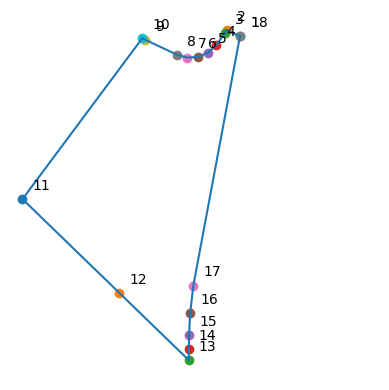

18


In [389]:
# Plot boundary IIIa
bndry_x = bndry_x_clsd[region]
bndry_y = bndry_y_clsd[region]

plot(bndry_x, bndry_y)
num_bndry_pts = length(bndry_x)
println(num_bndry_pts)
#scatter(bndry_x[20],bndry_y[20])#, turb_diam/2.0, fill=true,color="black")
# Plot boundary verticies
for i = 1:num_bndry_pts
     scatter(bndry_x[i],bndry_y[i])#, turb_diam/2.0, fill=true,color="black")
     plt.text(bndry_x[i]+turb_diam, bndry_y[i]+turb_diam, string(i))
end

# Formatting
axis("square")
axis("off")
plt.show()

In [360]:
# Show all the angles for region IIIa
calcSmallestAngle(bndry_x_clsd[region], bndry_y_clsd[region])

2: 95.73666520202987
3: 174.01958789468605
4: 169.96402967603632
5: 160.28804114285896
6: 160.57273451833328
7: 160.7386215275396
8: 170.1694460890394
9: 174.2502817261309
10: 95.76170560166011
11: 97.40565662797147
12: 179.99923435399694
13: 45.78713661831358
14: 178.94301943522277
15: 178.02043087097732
16: 176.35250557597874
17: 175.96337167909368
18: 104.59167173122069


45.78713661831358

In [557]:
# Test startup
start_dist = 0
test_num_turbs = 16
region = 1  # Which region we're placing turbines for
turbine_x, turbine_y, not_placed = VR_bounary_startup(bndry_x_clsd[region], bndry_y_clsd[region], start_dist, turb_min_space, test_num_turbs)#turbs_region_brdr[region])
print("Not Placed:", not_placed)

Not Placed:0

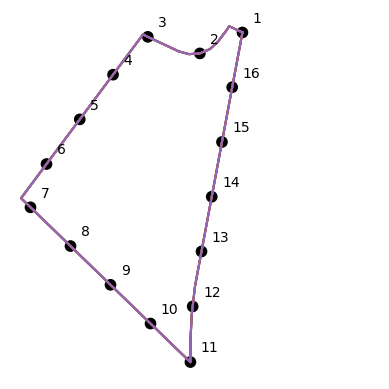

Min allowed dist: 396.0
Min actual  dist: 876.7473149112344


In [558]:
#- Visualize it all -#
# Plot boundary
for cntr in 1:nNumRegions
    plot(bndry_x_clsd[region], bndry_y_clsd[region])
end

# Plot turbines
for i = 1:length(turbine_x)
     plt.gcf().gca().add_artist(plt.Circle((turbine_x[i],turbine_y[i]), turb_diam/2.0, fill=true,color="black"))
     plt.text(turbine_x[i]+turb_diam,turbine_y[i]+turb_diam, string(i))
end

println("Min allowed dist: ", 2*turb_diam)
println("Min actual  dist: ", minimum(ff.turbine_spacing(turbine_x, turbine_y)))


# Formatting
axis("square")
axis("off")
plt.show()

# Unit test cases in FlowFarm

### One turbine

In [695]:
#-- One-turbine circular boundary, zero start distance  --#
# A discretized 20-point circle
bndry_x_clsd = [200.00, 195.11, 180.90, 158.78, 130.90, 100.00, 69.10, 41.22, 19.10, 4.89, 0.00, 4.89, 19.10, 41.22, 69.10, 100.00, 130.90, 158.78, 180.90, 195.11, 200.00]
bndry_y_clsd = [100.00, 130.90, 158.78, 180.90, 195.11, 200.00, 195.11, 180.90, 158.78, 130.90, 100.00, 69.10, 41.22, 19.10, 4.89, 0.00, 4.89, 19.10, 41.22, 69.10, 100.00]
# Give it one small turbine, at the start
num_turbs = 1
start_dist = 0
turb_diam = 10.0
turb_min_spacing = 2*turb_diam

testing_x, testing_y, num_leftover = VR_boundary_startup(bndry_x_clsd, bndry_y_clsd, start_dist, turb_min_spacing, num_turbs)
test_values = [200.00, 100.0, 0]
#@test ff.VR_bounary_startup(bndry_x_clsd, bndry_y_clsd, start_dist, turb_min_spacing, num_turbs) == test_values
println(test_values[1] == bndry_x_clsd[1])
println(test_values[2] == bndry_y_clsd[1])
println(test_values[3] == 0)

true
true
true


In [689]:
#-- One-turbine square boundary, zero start distance  --#
# A discretized 20-point circle
bndry_x_clsd = [100.0, 0.0, 0.0, 100.0, 100.0]
bndry_y_clsd = [100.0, 100.0, 0.0, 0.0, 100.0]
# Give it one small turbine, at the start
num_turbs = 1
start_dist = 0
turb_diam = 10.0
turb_min_spacing = 2*turb_diam

testing_x, testing_y, num_leftover = VR_boundary_startup(bndry_x_clsd, bndry_y_clsd, start_dist, turb_min_spacing, num_turbs)
test_values = [bndry_x_clsd[1], bndry_y_clsd[1], 0]
#@test ff.VR_bounary_startup(bndry_x_clsd, bndry_y_clsd, start_dist, turb_min_spacing, num_turbs) == test_values
println(testing_x == test_values[1])
println(testing_y == test_values[2])
println(num_leftover == test_values[3])

true
true
true


In [693]:
#-- One-turbine circular boundary, 90deg start distance  --#
# A discretized 20-point circle
bndry_x_clsd = [200.00, 195.11, 180.90, 158.78, 130.90, 100.00, 69.10, 41.22, 19.10, 4.89, 0.00, 4.89, 19.10, 41.22, 69.10, 100.00, 130.90, 158.78, 180.90, 195.11, 200.00]
bndry_y_clsd = [100.00, 130.90, 158.78, 180.90, 195.11, 200.00, 195.11, 180.90, 158.78, 130.90, 100.00, 69.10, 41.22, 19.10, 4.89, 0.00, 4.89, 19.10, 41.22, 69.10, 100.00]
# Give it one small turbine, perturb the start
num_turbs = 1
start_dist = (pi/2)*100 # Top of the circle
turb_diam = 10.0
turb_min_spacing = 2*turb_diam

testing_x, testing_y, num_leftover = VR_boundary_startup(bndry_x_clsd, bndry_y_clsd, start_dist, turb_min_spacing, num_turbs)
test_values = [100.00, 200.0, 0]
#@test ff.VR_bounary_startup(bndry_x_clsd, bndry_y_clsd, start_dist, turb_min_spacing, num_turbs) == test_values
println(test_values[1] == bndry_x_clsd[6])
println(test_values[2] == bndry_y_clsd[6])
println(test_values[3] == 0)


true
true
true


In [691]:
#-- One-turbine square boundary, 90deg start distance  --#
# A discretized 20-point circle
bndry_x_clsd = [100.0, 0.0, 0.0, 100.0, 100.0]
bndry_y_clsd = [100.0, 100.0, 0.0, 0.0, 100.0]
# Give it one small turbine, at the start
num_turbs = 1
start_dist = 100.0
turb_diam = 10.0
turb_min_spacing = 2*turb_diam

testing_x, testing_y, num_leftover = VR_boundary_startup(bndry_x_clsd, bndry_y_clsd, start_dist, turb_min_spacing, num_turbs)
test_values = [0.0, 100.0, 0]
#@test ff.VR_bounary_startup(bndry_x_clsd, bndry_y_clsd, start_dist, turb_min_spacing, num_turbs) == test_values
println(test_values[1] == bndry_x_clsd[2])
println(test_values[2] == bndry_y_clsd[2])
println(test_values[3] == 0)

true
true
true


### Multi-turbine

In [687]:
# Multi-Turbine, Square Boundary, Zero Start Distance
# A 4-point sqaure
bndry_x_clsd = [100.0, 0.0, 0.0, 100.0, 100.0]
bndry_y_clsd = [100.0, 100.0, 0.0, 0.0, 100.0]
# Give it a few turbines, perturb the start
num_turbs = 4
start_dist = 0.0 # Top side mid-point
turb_diam = 10.0
turb_min_spacing = 2*turb_diam

testing_x, testing_y, num_leftover = ff.VR_boundary_startup(bndry_x_clsd, bndry_y_clsd, start_dist, turb_min_spacing, num_turbs)
test_values_x = [100.0, 0.0, 0.0, 100.0]
test_values_y = [100.0, 100.0, 0.0, 0.0]
test_num_leftover = 0
#@test testing_x == test_values_x
#@test testing_y == test_values_y
#@test num_leftover == test_num_leftover

0

In [697]:
#-- Multi-turbine, Circular Boundary, Zero Start Distance--#
# A discretized 200-point circle
num_pts = 400
circ_radius = 100.0
circ_center = [100.0, 100.0]
bndry_x_clsd, bndry_y_clsd = ff.DiscreteCircum(circ_center[1], circ_center[2], circ_radius, num_pts)
# Vertices that keep splines injective (4-corners)
bndry_corner_indcies = [1, 51, 101, 151, 201]  # 200 pt circle, 4 corners
# Give it a few turbines, don't perturb the start
num_turbs = 8
start_dist = 0 # Right of the circle
turb_diam = 10.0
turb_min_spacing = 2*turb_diam

# Vertices that keep splines injective
circ_corners = 1/sqrt(2)
cc_r = circ_center[2] + (circ_corners * circ_radius) # ~170
cc_l = circ_center[1] - (circ_corners * circ_radius) # ~ 30
cc_d = cc_r - cc_l                # ~140
cc_d2 = cc_d/2                    # ~ 70

testing_x, testing_y, num_leftover = ff.VR_boundary_startup(bndry_x_clsd, bndry_y_clsd, start_dist, turb_min_spacing, num_turbs)
test_values_x = [200.0, cc_r, 100.0, cc_l, 0.0, cc_l, 100.0, cc_r]
test_values_y = [100.0, cc_r, 200.0, cc_r, 100.0, cc_l, 0.0, cc_l]
test_values_numleftover = [ [200.00, ],
                            [100.0, ],
                            0]
#@test test_values_x ≈ testing_x  atol=1E-10

3-element Array{Any,1}:
  [200.0]
  [100.0]
 0

In [700]:
#-- Multi-turbine, Circular Boundary, With Start Distance --#
# A discretized 200-point circle
num_pts = 400
circ_radius = 100.0
circ_center = [100.0, 100.0]
bndry_x_clsd, bndry_y_clsd = ff.DiscreteCircum(circ_center[1], circ_center[2], circ_radius, num_pts)
# Vertices that keep splines injective (4-corners)
bndry_corner_indcies = [1, 51, 101, 151, 201]  # 200 pt circle, 4 corners
# Give it a few turbines, don't perturb the start
num_turbs = 8
start_dist = 100*pi/4 # Top Right of the circle
turb_diam = 10.0
turb_min_spacing = 2*turb_diam

# Vertices that keep splines injective
circ_corners = 1/sqrt(2)
cc_r = circ_center[2] + (circ_corners * circ_radius) # ~170
cc_l = circ_center[1] - (circ_corners * circ_radius) # ~ 30
cc_d = cc_r - cc_l                # ~140
cc_d2 = cc_d/2                    # ~ 70

testing_x, testing_y, num_leftover = ff.VR_boundary_startup(bndry_x_clsd, bndry_y_clsd, start_dist, turb_min_spacing, num_turbs)
test_values_x = [cc_r, 100.0, cc_l, 0.0, cc_l, 100.0, cc_r, 200.0]
test_values_y = [cc_r, 200.0, cc_r, 100.0, cc_l, 0.0, cc_l, 100.0]
test_values_numleftover = [ [200.00, ],
                            [100.0, ],
                            0]
#@test test_values_x ≈ testing_x  atol=5E-3

3-element Array{Any,1}:
  [200.0]
  [100.0]
 0

In [684]:
# Multi-Turbine, Square Boundary, With Start Distance
# A 4-point sqaure
bndry_x_clsd = [100.0, 0.0, 0.0, 100.0, 100.0]
bndry_y_clsd = [100.0, 100.0, 0.0, 0.0, 100.0]
# Give it a few turbines, perturb the start
num_turbs = 4
start_dist = 50.0 # Top side mid-point
turb_diam = 10.0
turb_min_spacing = 2*turb_diam

testing_x, testing_y, num_leftover = ff.VR_boundary_startup(bndry_x_clsd, bndry_y_clsd, start_dist, turb_min_spacing, num_turbs)
test_values_x = [50.0, 0.0, 50.0, 100.0]
test_values_y = [100.0, 50.0, 0.0, 50.0]
test_num_leftover = 0
#@test testing_x == test_values_x
#@test testing_y == test_values_y
#@test num_leftover == test_num_leftover

0

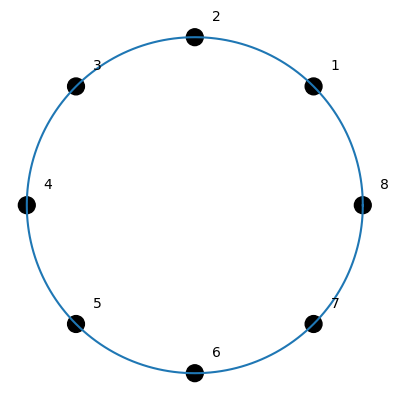

In [701]:
#- Visualize it all -#
# Plot boundary
plot(bndry_x_clsd, bndry_y_clsd)
# Plot turbines
for i = 1:length(testing_x)
     plt.gcf().gca().add_artist(plt.Circle((testing_x[i],testing_y[i]), turb_diam/2.0, fill=true,color="black"))
#     plt.gcf().gca().add_artist(plt.Circle((test_values_x[i],test_values_y[i]), turb_diam/2.0, fill=true,color="red"))
     plt.text(testing_x[i]+turb_diam,testing_y[i]+turb_diam, string(i))
end

# Formatting
axis("square")
axis("off")
plt.show()
#savefig("MulitCircleOff.pdf")

# Making Random Starting points (Julia)

`2026.22.July.20`

I just realized that for this to be properly implemented, I'll need to make some new starting points where some turbines are placed along each boundary, and the rest are randomly started inside. I could randomize the boundary turbine starting points as well, but the practice of using the example turbine layout as a starting point won't work here. I'll be putting that in a new notebook.